In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
df = pd.read_csv('CHLA_clean_data_until_2023.csv')

In [3]:
print(df.info())

categorical_cols = df.select_dtypes(include=['object', 'category'])
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21060 entries, 0 to 21059
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   MRN                                       21060 non-null  int64 
 1   APPT_STATUS                               21060 non-null  object
 2   APPT_DATE                                 21060 non-null  object
 3   BOOK_DATE                                 21060 non-null  object
 4   ZIPCODE                                   21060 non-null  object
 5   CLINIC                                    21060 non-null  object
 6   SCHEDULE_ID                               21060 non-null  int64 
 7   APPT_ID                                   21060 non-null  int64 
 8   LEAD_TIME                                 21060 non-null  int64 
 9   IS_REPEAT                                 21060 non-null  object
 10  APPT_TYPE_STANDARDIZE                     2106

There are 25 total columns, there are 13 categorical columns and 12 quantitative columns. Although MRN, SCHEDULE_ID, and APPT_ID are numerical they are identifier specific to the patient. 

Once the data is imported in Azure ML we will not include  MRN, SCHEDULE_ID, and APPT_ID into the dataset as they don't have predictive influence for our target variable. 
Then by "Edit Metadata" module forces the categorical variables for later encoding. This allows for the variables to be identified correctly by the model. 
The hot encoding was done by the "Covert to indictor values" and then "Execute Python Script" takes the column 'IS_REPEAT' where 'Y' is 1 and 'N' is 0. 

# Data Cleaning

Missing Values and Duplicates

In [4]:
#check for missing values
print(df.isnull().sum())

#check for duplicates
print(f'\nThere are {df.duplicated().sum()} duplicates')

MRN                                         0
APPT_STATUS                                 0
APPT_DATE                                   0
BOOK_DATE                                   0
ZIPCODE                                     0
CLINIC                                      0
SCHEDULE_ID                                 0
APPT_ID                                     0
LEAD_TIME                                   0
IS_REPEAT                                   0
APPT_TYPE_STANDARDIZE                       0
APPT_NUM                                    0
TOTAL_NUMBER_OF_CANCELLATIONS               0
TOTAL_NUMBER_OF_RESCHEDULED                 0
TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT    0
TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT         0
TOTAL_NUMBER_OF_NOSHOW                      0
DAY_OF_WEEK                                 0
WEEK_OF_MONTH                               0
NUM_OF_MONTH                                0
HOUR_OF_DAY                                 0
IS_NOSHOW                         

In [5]:
print(df[df.duplicated(keep=False)])

           MRN  APPT_STATUS       APPT_DATE      BOOK_DATE ZIPCODE  \
1410   1504926  CHECKED OUT    6/5/23 11:30   3/6/23 12:24   91354   
1411   1504926  CHECKED OUT    6/5/23 11:30   3/6/23 12:24   91354   
5518   4498039  CHECKED OUT  10/31/22 12:30  7/18/22 12:58   93551   
5519   4498039  CHECKED OUT  10/31/22 12:30  7/18/22 12:58   93551   
13884  1903041  CHECKED OUT   10/14/19 9:35  8/26/19 11:23   93110   
13885  1903041  CHECKED OUT   10/14/19 9:35  8/26/19 11:23   93110   
16518  1952700  RESCHEDULED   5/16/19 13:00   5/15/19 9:40   90028   
16519  1952700  RESCHEDULED   5/16/19 13:00   5/15/19 9:40   90028   

                     CLINIC  SCHEDULE_ID   APPT_ID  LEAD_TIME IS_REPEAT  ...  \
1410   VALENCIA CARE CENTER     22140573  75610549         90         Y  ...   
1411   VALENCIA CARE CENTER     22140573  75610549         90         Y  ...   
5518   VALENCIA CARE CENTER     21049588  71695168        104         Y  ...   
5519   VALENCIA CARE CENTER     21049588  7169516

In [6]:
df = df.drop_duplicates()

# Exploring Target Variable

### Target Column: IS_NOSHOW

Categorical Analysis (IS_NOSHOW):
IS_NOSHOW
N    20023
Y     1033
Name: count, dtype: int64
IS_NOSHOW
N    95.094035
Y     4.905965
Name: proportion, dtype: float64


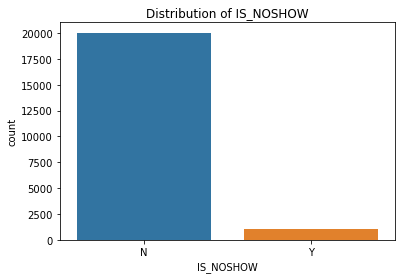

In [7]:
print("Categorical Analysis (IS_NOSHOW):")

# Distribution of target variable
print(df['IS_NOSHOW'].value_counts())
print(df['IS_NOSHOW'].value_counts(normalize=True) * 100)

# Visualization
sns.countplot(x='IS_NOSHOW', data=df)
plt.title('Distribution of IS_NOSHOW')
plt.show()

Due to this severe case of class imbalance once the data is loaded into Azure we will implement SMOTE and other strategies to create a better balance for the model training. 

# Review the Distribution of Potential Feature

In [24]:
numerical_columns = [col for col in numerical_cols if col not in ['MRN', 'SCHEDULE_ID', 'APPT_ID']]
numerical_columns= df[numerical_columns]


categorical_columns = [col for col in categorical_cols if col not in ['IS_NOSHOW', 'APPT_DATE', 'BOOK_DATE', 'ZIPCODE']]

# Univariate Analysis for Numerical Variables
print("Summary Statistics for Numerical Variables:")
print(numerical_columns.describe())



Summary Statistics for Numerical Variables:
          LEAD_TIME      APPT_NUM  TOTAL_NUMBER_OF_CANCELLATIONS  \
count  21056.000000  21056.000000                   21056.000000   
mean      58.140150      5.683226                       0.934223   
std       56.947639      4.798386                       1.173925   
min      -15.000000      1.000000                       0.000000   
25%       18.000000      2.000000                       0.000000   
50%       42.000000      4.000000                       1.000000   
75%       84.000000      7.000000                       1.000000   
max      895.000000     35.000000                      12.000000   

       TOTAL_NUMBER_OF_RESCHEDULED  TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT  \
count                 21056.000000                              21056.000000   
mean                      1.776263                                  0.003467   
std                       2.337098                                  0.064923   
min                    

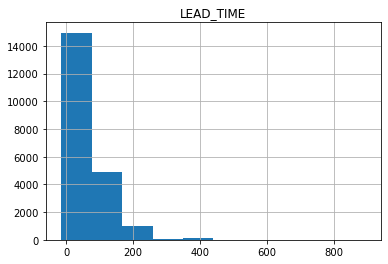

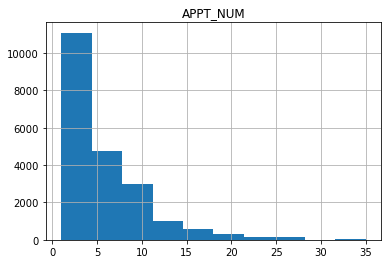

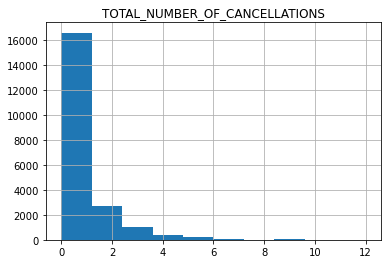

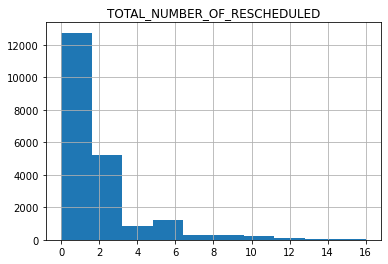

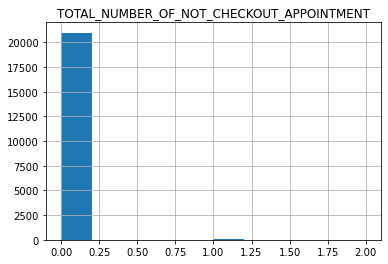

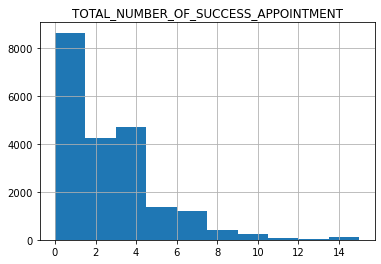

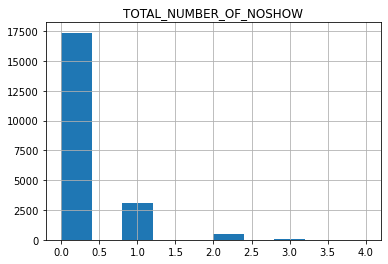

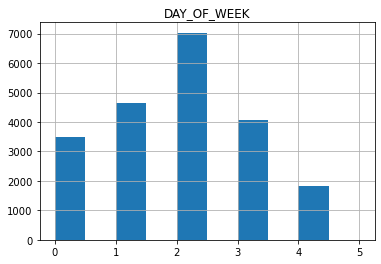

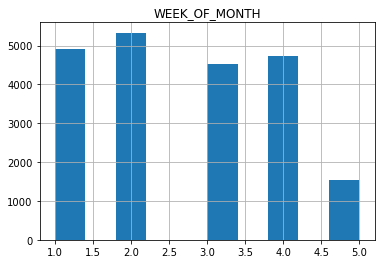

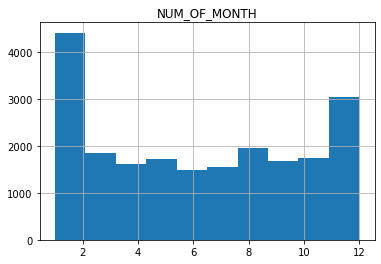

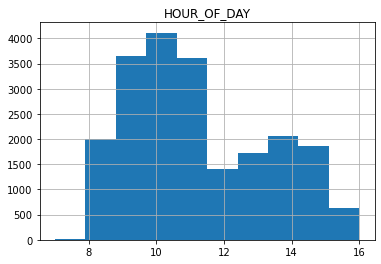

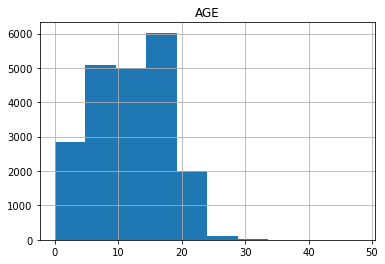

In [9]:
# Histograms for all numerical columns
for col in numerical_columns:
    df[col].hist()
    plt.title(col)
    plt.show()

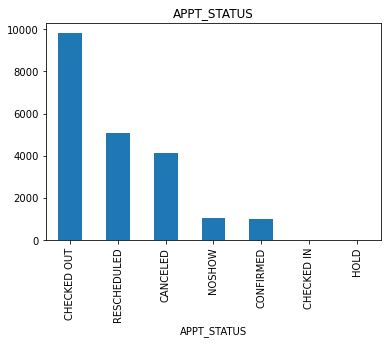

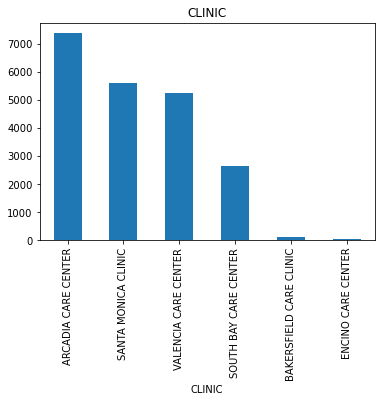

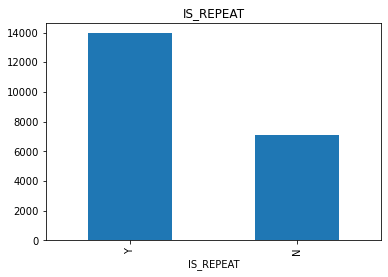

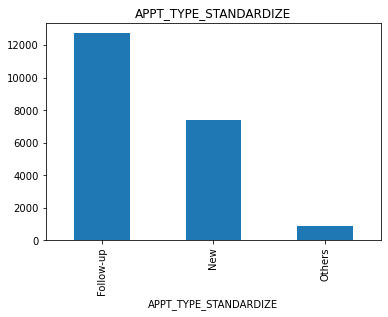

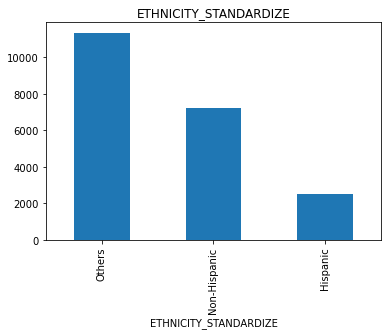

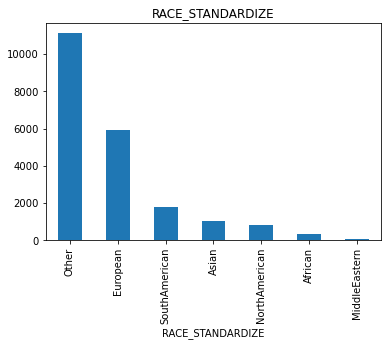

In [10]:
# Bar plots for all categorical columns
for col in categorical_columns:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    

In [11]:
#checking the unique values of categorical variables

for col in categorical_cols.columns:
    print(col, df[col].unique())

APPT_STATUS ['CONFIRMED' 'RESCHEDULED' 'CANCELED' 'CHECKED OUT' 'CHECKED IN' 'NOSHOW'
 'HOLD']
APPT_DATE ['12/26/23 10:30' '12/26/23 10:00' '12/21/23 10:30' ... '4/4/18 8:40'
 '3/20/18 12:10' '2/21/18 8:40']
BOOK_DATE ['6/6/23 10:32' '12/27/22 10:19' '1/23/23 10:59' ... '3/5/18 11:52'
 '3/20/18 9:15' '2/13/18 17:14']
ZIPCODE ['91387' '91354' '91350' '91402' '91326' '91355' '91351' '91405' '91709'
 '93550' '91744' '90049' '91381' '91335' '90042' '91207' '91118' '92019'
 '90230' '91384' '90650' '93535' '91103' '90274' '91344' '93225' '93309'
 '93314' '91343' '90046' '91748' '91304' '93534' '93510' '90265' '90026'
 '91104' '90604' '90304' '90804' '90744' '91030' '91436' '91724' '90016'
 '91202' '91737' '93561' '91342' '90293' '90806' '90262' '90731' '90805'
 '90606' '91001' '93552' '91206' '91007' '90064' '93560' '91321' '90601'
 '91006' '90247' '90746' '91024' '90201' '90638' '90505' '91325' '93551'
 '91367' '93103' '91311' '93305' '91301' '90019' '91214' '91790' '89123'
 '90277' '90255'

# Bivariate Analysis

### Quantitative Variables

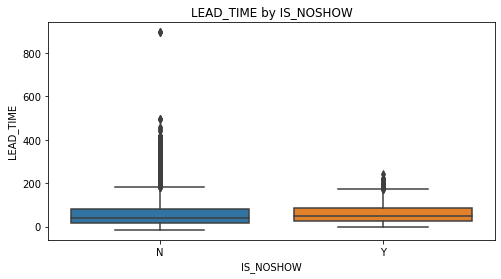

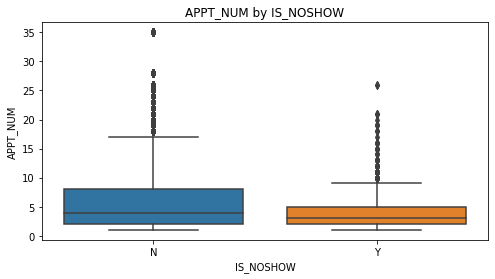

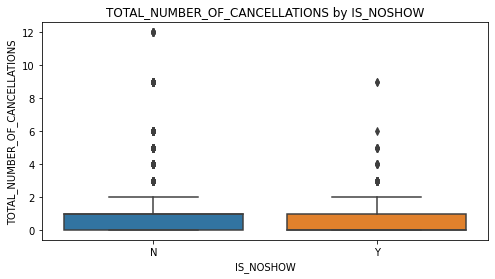

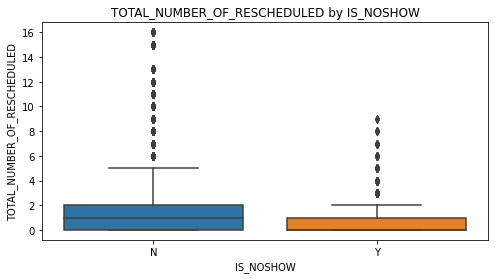

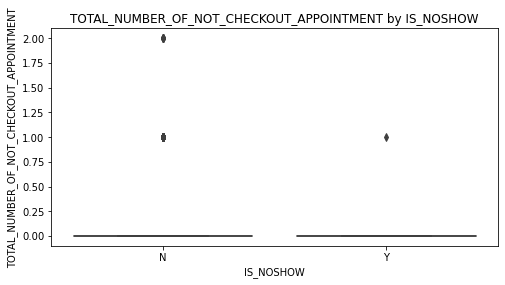

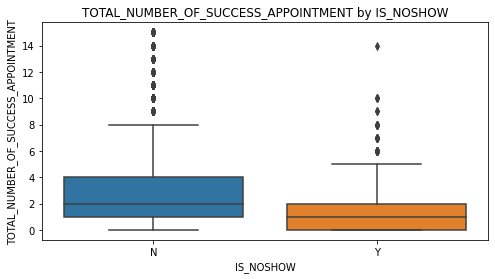

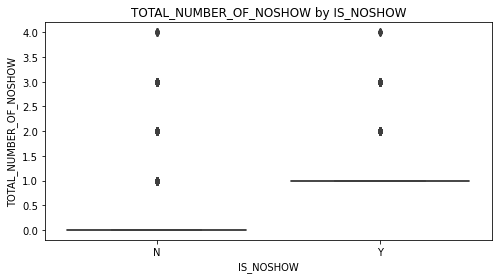

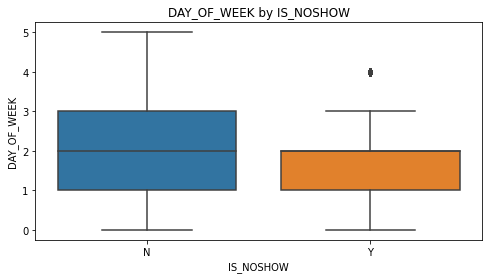

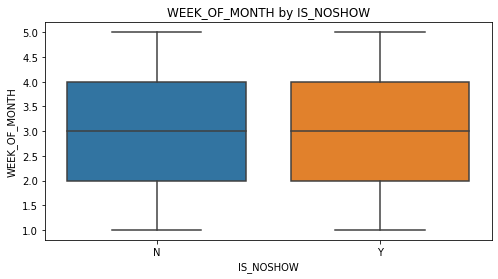

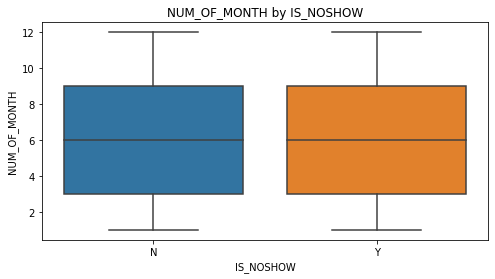

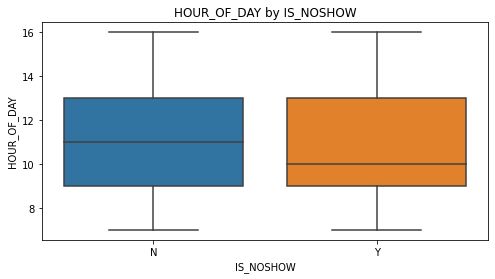

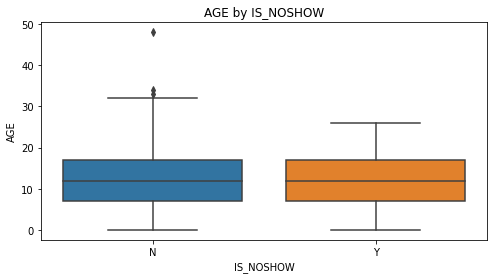

In [22]:
# Examine relationships between features and the IS_NOSHOW
# Box plots for numerical columns against IS_NOSHOW
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='IS_NOSHOW', y=col, data=df)
    plt.title(f'{col} by IS_NOSHOW')
    plt.show()

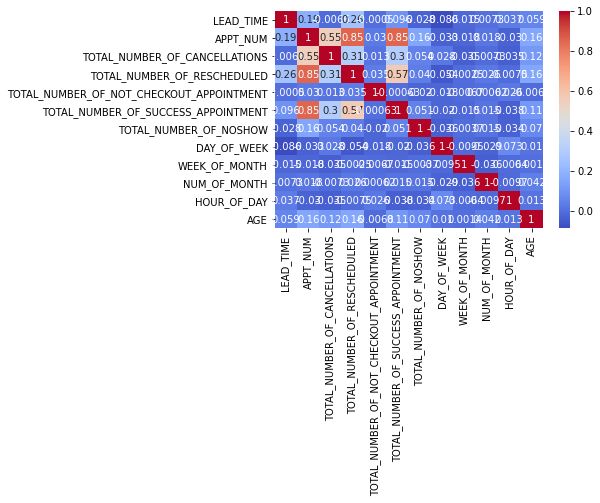

In [25]:
# Correlation matrix for numerical columns
corr = numerical_columns.corr()

# Heatmap for the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

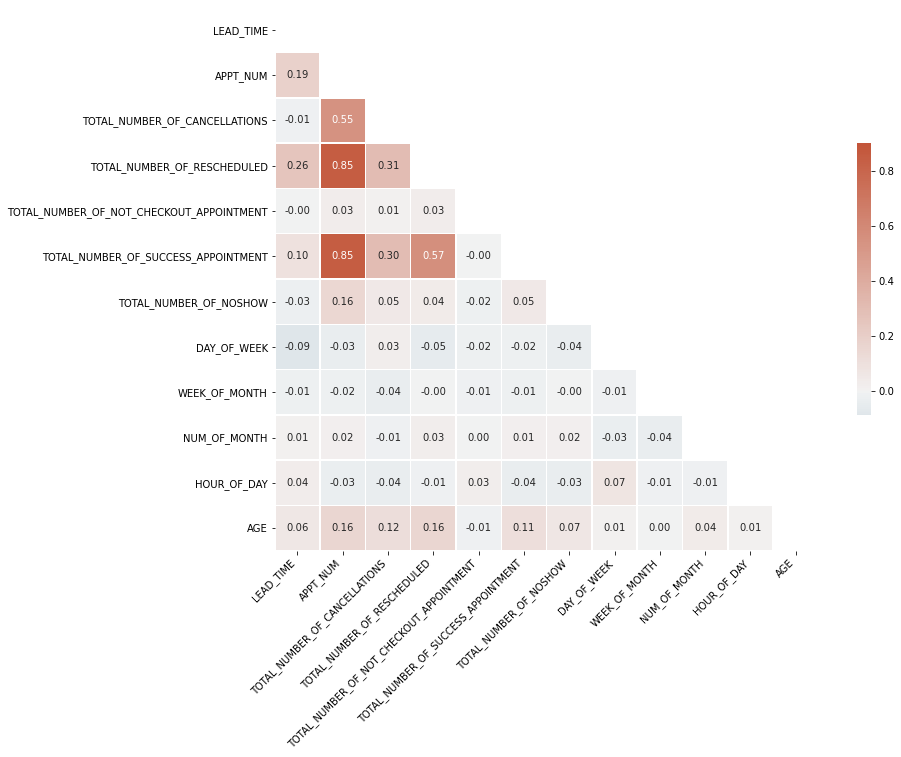

In [27]:
## Prettier version of the correlation heat map 

corr = numerical_columns.corr()  # Compute the correlation matrix

# Increase the figure size
plt.figure(figsize=(14, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# Rotate x-axis labels and increase font size for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.show()

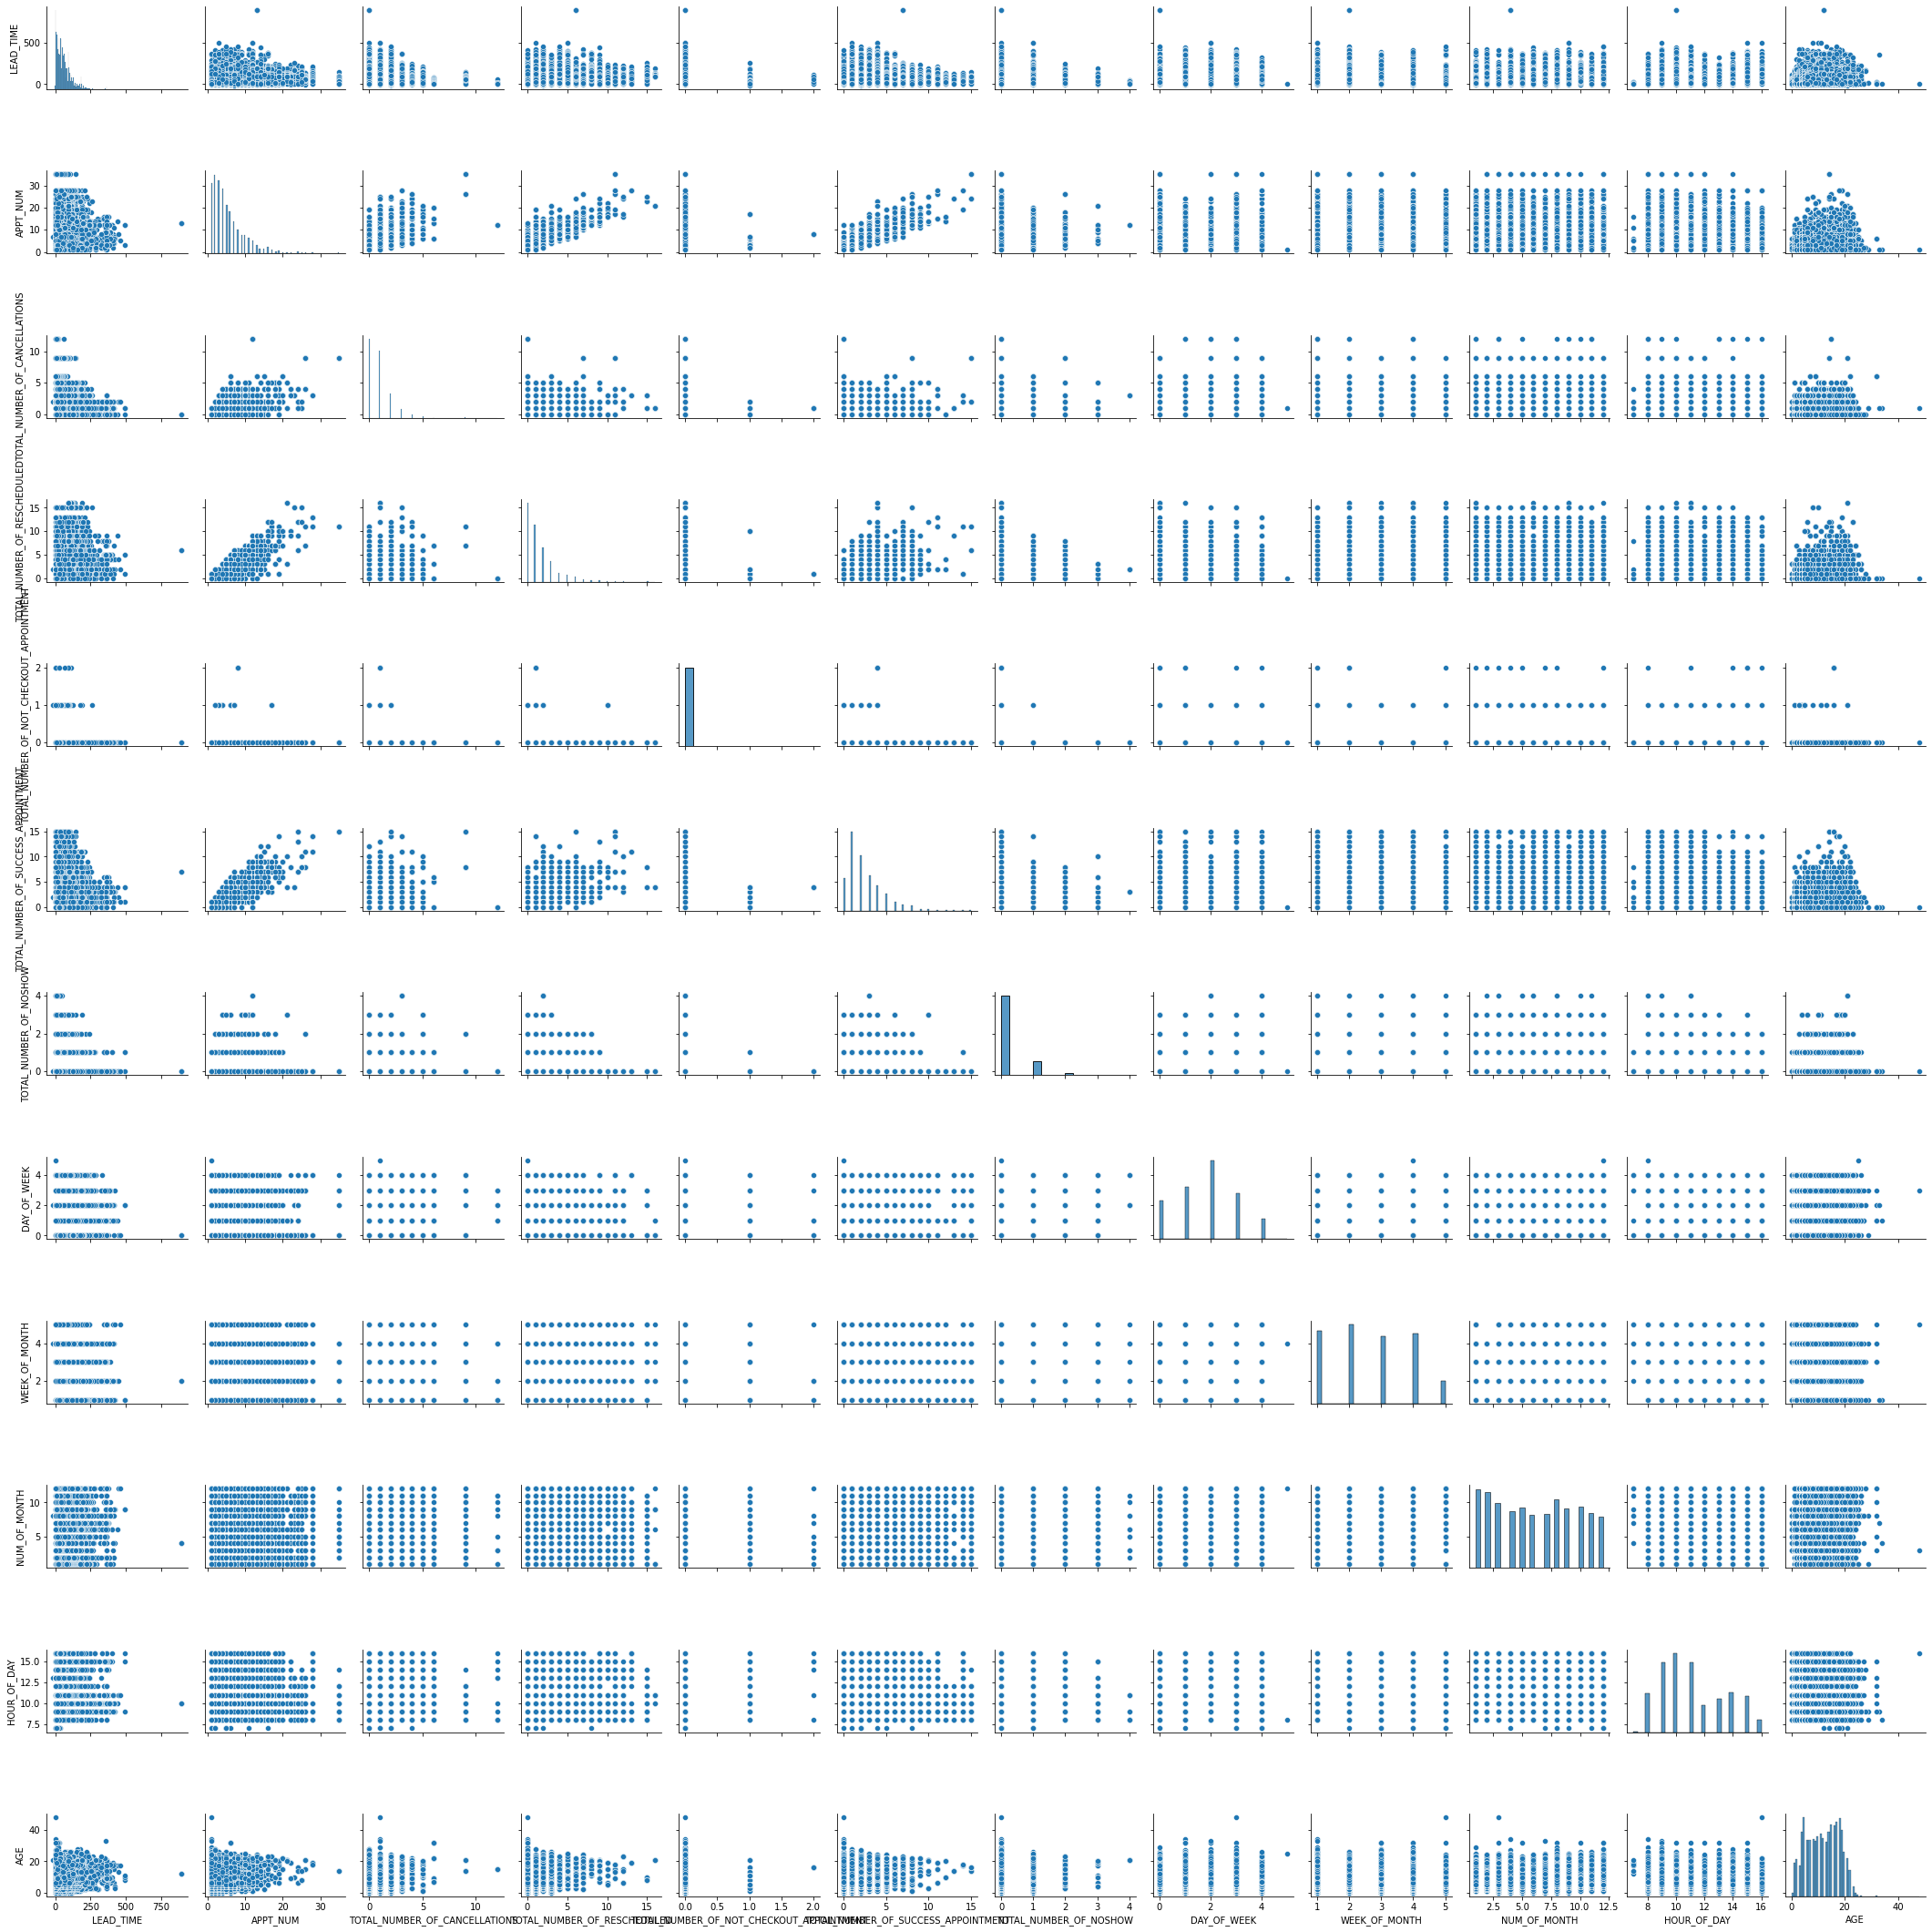

In [15]:
sns.pairplot(numerical_columns)
plt.show()

In [16]:
numerical_columns = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ['MRN', 'SCHEDULE_ID', 'APPT_ID']]

# Create a DataFrame to hold features and their VIF scores
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_columns 

# Ensure 'df' is subsetted correctly for VIF calculation
numerical_df_for_vif = df[numerical_columns].dropna()

# Adjusting the VIF calculation to work with 'numerical_df_for_vif'
vif_data["VIF"] = [variance_inflation_factor(numerical_df_for_vif.values, i) for i in range(len(numerical_df_for_vif.columns))]

print(vif_data)

                                     feature         VIF
0                                  LEAD_TIME    2.278408
1                                   APPT_NUM  330.775637
2              TOTAL_NUMBER_OF_CANCELLATIONS   14.971640
3                TOTAL_NUMBER_OF_RESCHEDULED   55.028195
4   TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT    1.026018
5        TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT   78.885699
6                     TOTAL_NUMBER_OF_NOSHOW    2.772105
7                                DAY_OF_WEEK    3.301882
8                              WEEK_OF_MONTH    4.771741
9                               NUM_OF_MONTH    3.775803
10                               HOUR_OF_DAY   10.915866
11                                       AGE    4.886022


## Categorical Variables v IS_NOSHOW

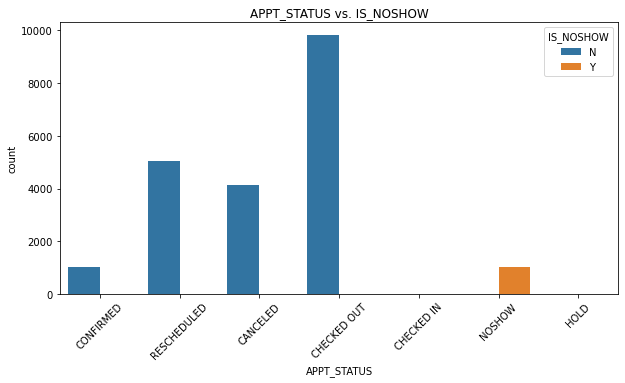

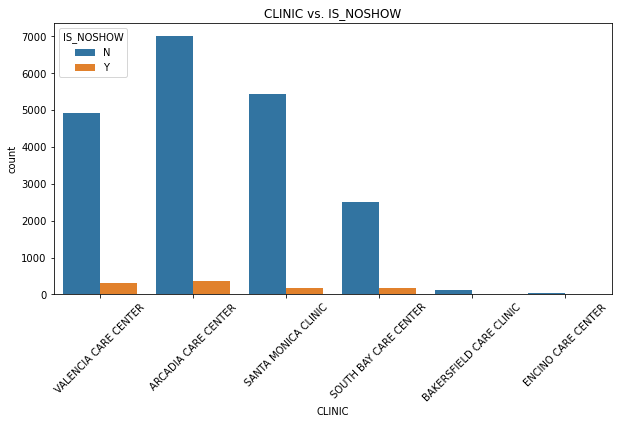

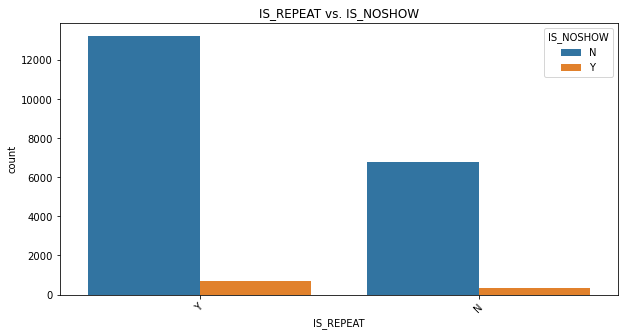

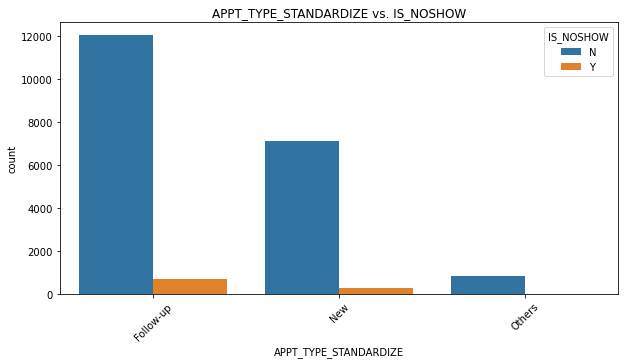

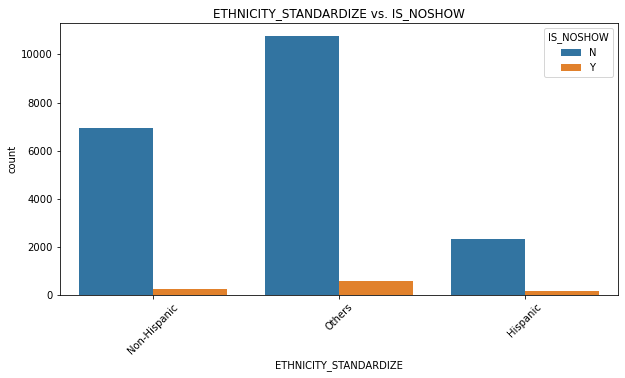

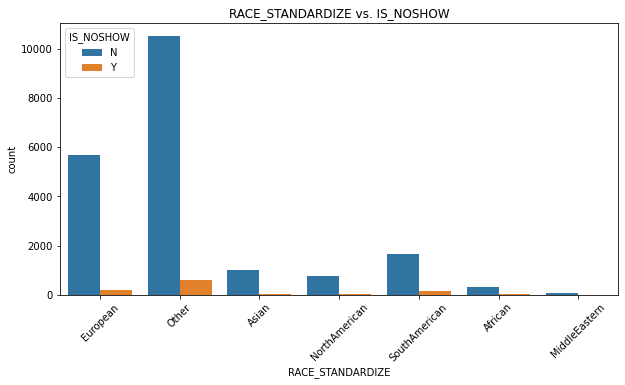

In [19]:
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='IS_NOSHOW', data=df)
    plt.title(f'{col} vs. IS_NOSHOW')
    plt.xticks(rotation=45)
    plt.show()


# Outliers Detection and Cleaning

We want to remove outliers, but due to the severe class imbalance if we just drop all the outliers we risk lowering our data for that column. So here is the selective removal of outliers

In [17]:
def remove_outliers(df, column_names, target_column):
    clean_df = df.copy()  # Create a copy of the DataFrame to keep the original data unchanged
    outliers_count = {}  # Dictionary to store the count of outliers for each column
    
    # Filter only rows where the target column is 'N'
    clean_df_no = clean_df[clean_df[target_column] == 'N']
    
    for column in column_names:
        Q1 = clean_df_no[column].quantile(0.25)
        Q3 = clean_df_no[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers before removal
        outliers_count[column] = sum((clean_df_no[column] < lower_bound) | (clean_df_no[column] > upper_bound))
        
        # Filter out outliers
        clean_df_no = clean_df_no[(clean_df_no[column] >= lower_bound) & (clean_df_no[column] <= upper_bound)]
    
    # Combine rows where target column is 'Yes' with cleaned rows where target column is 'No'
    clean_df = pd.concat([clean_df_no, clean_df[clean_df[target_column] == 'Y']])
    
    return clean_df, outliers_count




# List of numerical columns
numerical_columns = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ['MRN', 'SCHEDULE_ID', 'APPT_ID']]

# Remove outliers from the DataFrame and get outlier counts
clean_df, outliers_count = remove_outliers(df, numerical_columns, 'IS_NOSHOW')

print("Outliers count before removal:")
for column, count in outliers_count.items():
    print(f"{column}: {count}")

print(f"\nOriginal DataFrame size: {df.shape}")
print(f"Cleaned DataFrame size: {clean_df.shape}")


Outliers count before removal:
LEAD_TIME: 666
APPT_NUM: 1138
TOTAL_NUMBER_OF_CANCELLATIONS: 1097
TOTAL_NUMBER_OF_RESCHEDULED: 465
TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT: 46
TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT: 421
TOTAL_NUMBER_OF_NOSHOW: 1972
DAY_OF_WEEK: 0
WEEK_OF_MONTH: 0
NUM_OF_MONTH: 0
HOUR_OF_DAY: 0
AGE: 2

Original DataFrame size: (21056, 25)
Cleaned DataFrame size: (15249, 25)


In [18]:
print("Categorical Analysis (IS_NOSHOW):")
# Distribution Analysis
print(clean_df['IS_NOSHOW'].value_counts())
print(clean_df['IS_NOSHOW'].value_counts(normalize=True) * 100)

Categorical Analysis (IS_NOSHOW):
IS_NOSHOW
N    14216
Y     1033
Name: count, dtype: int64
IS_NOSHOW
N    93.225785
Y     6.774215
Name: proportion, dtype: float64


# Export Dataset

In [ ]:
clean_df.to_csv('Clean_CHLA_clean_data_until_2023.csv', index=False)